In [84]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import itertools

import pickle

from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from xgboost import XGBRegressor, XGBRFRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.base import clone




In [85]:
df = pd.read_csv("./combine_2010_2025")


In [86]:
# Excludes positions with heavier players
# df = df[df["Pos"].isin(["WR", "CB", "RB", "FS", "OLB", "ILB", "SS", "TE"])]

In [87]:

data = df[["Vertical", "Ht", "Wt"]].copy()
data["Relative-mass"] = df["Wt"] / df["Ht"] ** 3
data["Relative-vertical"] = df["Vertical"] / df["Ht"]
data["40yd"] = df["40yd"]
data = data.dropna()

X_original, y = data.drop(["40yd"], axis="columns"), data["40yd"]


In [88]:
feature_names = X_original.columns
feature_combinations = []
for i in range(1, len(feature_names)):
    i_length_combinations =itertools.combinations(feature_names, i)
    for combination in i_length_combinations:
        feature_combinations.append(combination)


In [89]:
data.corr()

,Vertical,Ht,Wt,Relative-mass,Relative-vertical,40yd
Vertical,1.000000,-0.409100,-0.638525,-0.557512,0.971428,-0.750982
Ht,-0.409100,1.000000,0.717502,0.195373,-0.611627,0.589288
Wt,-0.638525,0.717502,1.000000,0.820546,-0.734143,0.862213
Relative-mass,-0.557512,0.195373,0.820546,1.000000,-0.529799,0.723959
Relative-vertical,0.971428,-0.611627,-0.734143,-0.529799,1.000000,-0.797393
40yd,-0.750982,0.589288,0.862213,0.723959,-0.797393,1.000000


In [90]:
# Model definition
linear_regression = GridSearchCV(LinearRegression(), param_grid={})
lasso = GridSearchCV(LassoCV(), param_grid={})
ridge = GridSearchCV(RidgeCV(), param_grid={})
elastic_net = GridSearchCV(ElasticNetCV(), param_grid={})

random_forest = GridSearchCV(RandomForestRegressor(), {
    "n_estimators": [1, 10, 50, 100, 200, 500],
    "max_depth": [2, 3, 4, 5, 7, 10, None],
    "max_features": [1, 2, 3, 4],
    "bootstrap": [False, True]
})

extra_trees = GridSearchCV(ExtraTreesRegressor(), {
    "n_estimators": [10, 50, 100, 200, 500],    
    "max_depth": [2, 3, 4, 5, 7, 10, None],
    "max_features": [1, 2, 3, 4],
    "bootstrap": [False, True]
})

xgb = GridSearchCV(XGBRegressor(), {
    "n_estimators": [10, 50, 100, 200, 500],
    "max_depth": [2, 3, 4, 5, 7, 10, None],
    "learning_rate": [0.1, 0.05, 0.02, 0.01],
    "tree_method": ["auto", "approx"]
})

xgbrf = GridSearchCV(XGBRFRegressor(), {
    "n_estimators": [10, 50, 100, 200, 500],
    "max_depth": [2, 3, 4, 5, 7, 10, None],
    "tree_method": ["auto", "approx"]
})

mlp = GridSearchCV(MLPRegressor(), {
    ""
    "max_iter": [10000],
    "solver": ["lbfgs", "adam"],
    "hidden_layer_sizes": [(100, 50, 20), (200, 100, 40), (500, 200, 100, 50), (400, 300, 150, 50)]
})


In [91]:
models_df = pd.DataFrame({
    "LinearRegression": [clone(linear_regression) for _ in range(len(feature_combinations))],
    "LassoCV": [clone(lasso) for _ in range(len(feature_combinations))],
    "RidgeCV": [clone(ridge) for _ in range(len(feature_combinations))],
    "ElasticNetCV": [clone(elastic_net) for _ in range(len(feature_combinations))],
    "RandomForestRegressor": [clone(random_forest) for _ in range(len(feature_combinations))],
    "ExtraTreesRegressor": [clone(extra_trees) for _ in range(len(feature_combinations))],
    "XGBRegressor": [clone(xgb) for _ in range(len(feature_combinations))],
    "XGBRFRegressor": [clone(xgbrf) for _ in range(len(feature_combinations))],
    "MLPRegressor": [clone(mlp) for _ in range(len(feature_combinations))]
})

features_df = pd.DataFrame({
    "Features": feature_combinations
})
features_df["Scaler"] = features_df["Features"].apply(lambda _: StandardScaler()) # type: ignore
for i in features_df.index:
    features = features_df.loc[i, "Features"]
    scaler = features_df.loc[i, "Scaler"]
    X = X_original[list(features)].copy() # type: ignore
    scaler.fit(X) # type: ignore


In [ ]:
for i in models_df.index:
    features = features_df.loc[i, "Features"]
    scaler = features_df.loc[i, "Scaler"]
    X = X_original[list(features)].copy() # type: ignore
    X = scaler.transform(X) # type: ignore
    for col in models_df.columns:
        model = models_df.loc[i, col]
        model.fit(X, y) # type: ignore


In [ ]:


with open("pickled_models/model_selection.pickle", "wb") as file:
    pickle.dump((models_df, features_df), file)

NameError: name 'pickle' is not defined

In [ ]:
with open("models.pickle", "rb") as file:
    models_df = pickle.load(file)



In [ ]:

var = X_original.var()

for key, model in models_df.items():
    mse = model.cv_results_["mean_test_score"].min()
    r_score = 1 - mse / var
    print(key.ljust(30) + str(r_score))

NameError: name 'X_test' is not defined

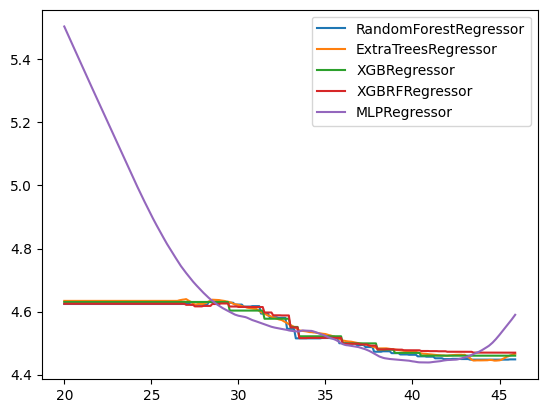

In [ ]:

vertical = list(np.arange(20, 46, 0.1))
my_data = pd.DataFrame({
    "Vertical": vertical,
    "Ht": [70] * len(vertical),
})
my_data = scaler.transform(my_data)

for key, model in models_df.items():
    prediction = model.predict(my_data)
    plt.plot(vertical, prediction, label=key)

plt.legend()
plt.show()

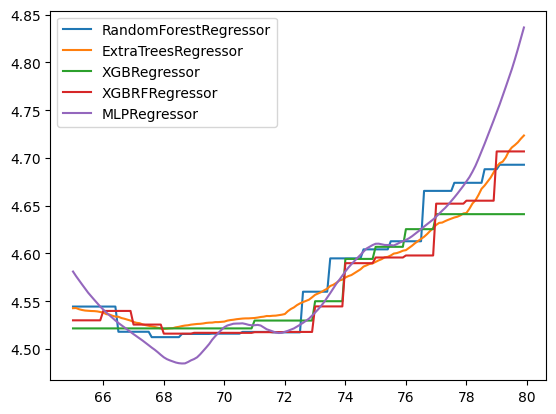

In [ ]:
model = mlp
ht = list(np.arange(65, 80, 0.1))
my_data = pd.DataFrame({
    "Vertical": [35] * len(ht),
    "Ht": ht,
})
my_data = scaler.transform(my_data)
for key, model in models_df.items():
    prediction = model.predict(my_data)
    plt.plot(ht, prediction, label=key)

plt.legend()
plt.show()

In [ ]:
layer = models_df["MLPRegressor"].cv_results_["param_hidden_layer_sizes"]
score = models_df["MLPRegressor"].cv_results_["mean_test_score"]

i = 0
while i < len(score):
    print(f"Layers: {layer[i]}")
    print(f"Score1: {score[i]}")
    print(f"Score2: {score[i + 1]}")
    print()
    i += 2


Layers: (100, 50, 20)
Score1: 0.06879750326948735
Score2: 0.25397138638946704

Layers: (200, 100, 40)
Score1: 0.1446302060601901
Score2: 0.2811618552346837

Layers: (500, 200, 100, 50)
Score1: 0.14710801006750568
Score2: 0.30851274333395834

Layers: (600, 500, 200, 100, 50)
Score1: 0.14509079689860838
Score2: 0.2890261800381679

Layers: (500, 400, 300, 210, 160, 120, 80, 50)
Score1: 0.13869871339641796
Score2: 0.2842237377969307



In [ ]:
models_df["MLPRegressor"].best_params_

{'hidden_layer_sizes': (500, 200, 100, 50),
 'max_iter': 10000,
 'solver': 'adam'}